In [83]:
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_predict, StratifiedKFold
from sklearn.grid_search import GridSearchCV
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 
import pandas
from numpy import log, inf, linspace, arctan, nan

68
70
77


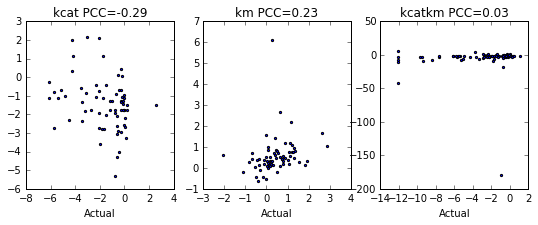

In [110]:
# clean up experimental data 

df = pandas.read_csv( 'data_sets/plos2015.csv', index_col='name' )
wt = df.loc[ 'BglB' ]
df.drop( [ 'BglB' ], inplace=True )
df = log( df / wt )

targets = [
    ( 'kcat', df.kcat ), 
    ( 'km', df.km ), 
    ( 'kcatkm', df.kcatkm ),
]

# clean up enzyme design features

f = pandas.read_csv( 'data_sets/scorefile.csv' ) 
f = f.groupby( 'name' ).apply( lambda x: x.mean() ) 

features = [ u'total_score', u'fa_rep', u'hbond_sc', u'tot_pstat_pm',
       u'tot_nlpstat_pm', u'tot_burunsat_pm', u'tot_hbond_pm',
       u'tot_NLconts_pm', u'tot_nlsurfaceE_pm', u'tot_total_charge',
       u'tot_total_pos_charges', u'tot_total_neg_charges', u'tot_seq_recovery',
       u'SR_1_total_score', u'SR_1_fa_rep', u'SR_1_hbond_sc',
       u'SR_1_hbond_pm', u'SR_1_burunsat_pm',
       u'SR_1_pstat_pm', u'SR_1_nlpstat_pm', u'SR_2_total_score',
       u'SR_2_fa_rep', u'SR_2_hbond_sc', u'SR_2_all_cst', u'SR_2_hbond_pm',
       u'SR_2_burunsat_pm', u'SR_2_pstat_pm', u'SR_2_nlpstat_pm',
       u'SR_3_total_score', u'SR_3_fa_rep', u'SR_3_hbond_sc', 
       u'SR_3_hbond_pm', u'SR_3_burunsat_pm', u'SR_3_pstat_pm',
       u'SR_3_nlpstat_pm', u'SR_4_total_score', u'SR_4_fa_rep',
       u'SR_4_hbond_sc', u'SR_4_hbond_pm',
       u'SR_4_burunsat_pm', u'SR_4_pstat_pm', u'SR_4_nlpstat_pm',
       u'SR_5_total_score', u'SR_5_fa_rep', u'SR_5_hbond_sc', u'SR_5_all_cst',
       u'SR_5_interf_E_1_2', u'SR_5_dsasa_1_2', u'SR_5_hbond_pm',
       u'SR_5_burunsat_pm' ] 

plt.figure( figsize=( 9, 3 ) ) 

for i, ( name, target ) in enumerate( targets ):
    
    # read in data 
    J = f.join( target ).replace( [ -inf, inf ], nan ).dropna()
    X = J[ features ] 
    y = J[ name ] 
    print len( y ) 

    # init ML models
    skf = StratifiedKFold( y, n_folds=10 ) 
    net = ElasticNetCV()
    bag = BaggingRegressor( net, n_estimators=1, max_features=1., max_samples=.9 ) 
    pln = Pipeline([
        ( 'scaler', StandardScaler() ), 
        ( 'bag', bag ) , 
    ])
    
    # cross-validate the bag 
    preds = cross_val_predict( pln, X, y, cv=10 ) 
    R = pearsonr( y, preds )  

    # plot actual versus predicted for training set 
    plt.subplot( 1, 3, i + 1 ) 
    plt.scatter( y, preds, marker='.' ) 
    plt.xlabel( 'Actual' ) 
    plt.title( '{0} PCC={1:.2f}'.format( name, R[0] ) )